# Acquiring data on cities

This notebook acquires data about cities that GANS operates in from Wikipedia (via web scraping) and OpenWeatherMap (via API access).

## Import libraries 💾

In [1]:
#! pip install lat_lon_parser
#! pip install geopy
#!pip install timezonefinder

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import urllib
import json
import lat_lon_parser
import re
import email.utils 
from geopy import distance
from pytz import timezone, utc
from timezonefinder import TimezoneFinder
import dotenv
import os
from sqlalchemy import create_engine, text, inspect

## Credentials
For storing your MySQL parameters (including password) and your OpenWeatherMap API key, make a `.env` file in the directory holding this notebook with the following content:
```env
# parameters for MySQL
host="127.0.0.1"
user="user"
password="password"
port=3306
# API key for OpenWeatherMap
openweathermap_key="key"
# API key for AeroDataBox
aerodatabox_key="key"
```

## SQL schema

In [3]:
# Record url, dt and ID for any scraped resources
scrape_list: list[tuple[str, datetime, int]] = []

In [4]:
def connect_sql():
  """
  Open connection to SQL database

  This reads connection parameters and credentials from `.env`.

  :return: SQLAlchemy connection object
  """
  dotenv.load_dotenv()

  schema = "wbscs_cities"
  host = os.getenv('host')
  user = os.getenv('user')
  password = os.getenv('password')
  port = os.getenv('port')

  connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

  return create_engine(connection_string).connect()

connection = connect_sql()

In [5]:
def reset_database():
    """
    Drop all SQL tables in the cities DB.
    """
    connection.execute(text('DROP TABLE IF EXISTS flight;'))
    connection.execute(text('DROP TABLE IF EXISTS city_airport;'))
    connection.execute(text('DROP TABLE IF EXISTS airport;'))
    connection.execute(text('DROP TABLE IF EXISTS weather;'))
    connection.execute(text('DROP TABLE IF EXISTS fact;'))
    connection.execute(text('DROP TABLE IF EXISTS city;'))
    connection.execute(text('DROP TABLE IF EXISTS measure;'))
    connection.execute(text('DROP TABLE IF EXISTS scrape;'))
    # consequently reset scrape database IDs
    for scrape in scrape_list:
      scrape[2] = None

def init_database():
    """
    Initialize SQL table schema if not previously done.

    This will not do anything if any tables already exist.
    """
    if len(inspect(connection).get_table_names()):
        return

    connection.execute(text(
        '''
        CREATE TABLE city (
            id INT AUTO_INCREMENT KEY,
            name TEXT NOT NULL,
            country TEXT,
            latitude DOUBLE,
            longitude DOUBLE,
            base_elevation TEXT,
            peak_elevation TEXT
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE scrape (
            id INT AUTO_INCREMENT KEY,
            url TEXT NOT NULL,
            timestamp TIMESTAMP NOT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE measure (
            id INT AUTO_INCREMENT KEY,
            name TEXT NOT NULL,
            type TEXT NOT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE fact (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            city INT NOT NULL REFERENCES city(id) ON DELETE CASCADE ON UPDATE CASCADE,
            measure INT NOT NULL REFERENCES measure(id) ON DELETE CASCADE ON UPDATE CASCADE,
            value TEXT NOT NULL,
            meta JSON NULL DEFAULT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE weather (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            city INT NOT NULL REFERENCES city(id) ON DELETE CASCADE ON UPDATE CASCADE,
            dt DATETIME NOT NULL,
            T_celsius FLOAT NOT NULL,
            T_feelslike_celsius FLOAT NOT NULL,
            wind_speed_mps FLOAT NOT NULL,
            wind_gust_mps FLOAT NOT NULL,
            rain_3h_mm FLOAT NOT NULL,
            snow_3h_mm FLOAT NOT NULL
        );
        '''));
    
    connection.execute(text(
        '''
        CREATE TABLE airport (
            icao CHAR(4) KEY,
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            iata TEXT NOT NULL,
            name TEXT NOT NULL,
            latitude DOUBLE NOT NULL,
            longitude DOUBLE NOT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE city_airport (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            city INT NOT NULL REFERENCES city(id) ON DELETE CASCADE ON UPDATE CASCADE,
            icao CHAR(4) NOT NULL REFERENCES airport(icao) ON DELETE CASCADE ON UPDATE CASCADE,
            distance_km DOUBLE NOT NULL
        );
        '''));

    connection.execute(text(
        '''
        CREATE TABLE flight (
            scrape INT NOT NULL REFERENCES scrape(id) ON DELETE CASCADE ON UPDATE CASCADE,
            origin_icao CHAR(4) NOT NULL REFERENCES airport(icao) ON DELETE CASCADE ON UPDATE CASCADE,
            scheduled_time TIMESTAMP NOT NULL,
            destination_icao CHAR(4) NULL,
            destination_name TEXT NOT NULL,
            number TEXT NOT NULL,
            type ENUM('departure', 'arrival') NOT NULL
        );
        '''));

In [6]:
def get_scrape_id(index: int):
  """
  Get or make scrape ID for `scrape` table.
  
  :param index: index into the `scrape_list`
  :return: the new scrape ID
  """
  scrape = scrape_list[index]
  if (id := scrape[2]) != None:
    return id
  redacted_url=re.sub(r'appid=\w+\b', 'appid=[redacted]', scrape[0])
  id = connection.execute(text(f'insert into scrape(url, timestamp) values("{redacted_url}", FROM_UNIXTIME({scrape[1].timestamp()})) returning id')).first().id
  scrape[2] = id
  return id

In [47]:
def read_scrapes():
  """
  Read list of scrapes from DB
  
  :return: data-frame with scrape meta-data
  """
  return pd.read_sql('scrape', con=connection).set_index('id')

In [7]:
def get_or_create_measure_id(measure: str, type_: str):
  """
  Get or create type of measurement in the `measure` table and return ID.

  :param measure: name of the measure
  :param type_: type of the measure
    The `type` is used as an annotation on how to interpret the `value`
    stored in the `fact` table which is physically always stored as a string.
  :return: the measure ID
  """
  try:
    return connection.execute(text(f'select id from measure where name="{measure}" and type="{type_}"')).first().id
  except AttributeError:
    return connection.execute(text(f'insert into measure(name, type) values("{measure}", "{type_}") returning id')).first().id

In [54]:
def read_measures():
  """
  Read list of measures from DB
  
  :return: data-frame
  """
  return pd.read_sql('measure', con=connection).set_index('id')

## Web scraping infrastructure

In [8]:
def parse_number(number: str):
  """
  Remove thousands separator (',') and parse the first number (integer only)

  :param number: the string to parse as a number
  :return: the parsed number
    or None if no number was found
  """
  if match := re.search(r'(\d+)', number.replace(',', '')):
    return int(match.group(1))
  return None

In [8]:
def parse_date(date: str):
  """
  Search for and parse any of the following date-formats in parentheses:
  - (31 December 2018)
  - (2018-12-31)
  - (2022)
  Trailing other text is allowed inside the parentheses if separated by whitespace.

  :param date: string containing the date
  :return: date as string in format `yyyy-mm-dd` or `yyyy`
    or None if not found.
  """
  # 31 December 2018, see Zürich
  if match := re.search(r'\((\d+ \w+ \d{4})(\s.*)?\)', date):
    return datetime.strptime(match.group(1), '%d %B %Y').strftime('%Y-%m-%d')
  # 2018-12-31, see Hamburg
  if match := re.search(r'\((\d{4}-\d\d-\d\d)(\s.*)?\)', date):
    return match.group(1)
  # 2022, see most others
  if match := re.search(r'\((20\d\d)(\s.*)?\)', date):
    return match.group(1)
  return None

In [9]:
def get_soup(url: str):
  """
  Retrieve HTML soup from URL using a local soup cache.

  If the URL was previously retrieved, the cached soup is served instead of making a web request.
  If the URL is requested from the web, the soup is stored in the cache.

  :param url: the URL to retrieve from cache or web
  :return: (soup, scrape_index) where scrape_index refers to the scrape_list
  """
  try:
    if cached := get_soup.cache.get(url):
      return cached
  except:
    get_soup.cache = {}
    
  dt = datetime.now()
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  # dt = email.utils.parsedate_to_datetime(response.headers['date'])
  scrape_index = len(scrape_list)
  scrape_list.append([url, dt, None])
  get_soup.cache[url] = (soup, scrape_index)
  return (soup, scrape_index)

## Web scraping Wikipedia

Utilise your web scraping skills to gather information about three German cities – Berlin, Hamburg, and Munich – from Wikipedia. You will start by extracting the population of each city and then expand the scope of your data gathering to include latitude and longitude, country, and possibly other relevant details.

1. Population Scraping

  1.1. Begin by scraping the population of each city from their respective Wikipedia pages:

 - Berlin: https://en.wikipedia.org/wiki/Berlin
 - Hamburg: https://en.wikipedia.org/wiki/Hamburg
 - Munich: https://en.wikipedia.org/wiki/Munich

  1.2. Once you have scrapped the population of each city, reflect on the similarities and patterns in accessing the population data across the three pages. Also, analyse the URLs to identify any commonalities. Make a loop that executes once but simultaneously retrieves the population for all three cities.

2. Data Organisation

  Utilise pandas DataFrame to effectively store the extracted population data. Ensure the data is clean and properly formatted. Remove any unnecessary characters or symbols and ensure the column data types are accurate.

3. Further Enhancement

  3.1. Expand the scope of your data gathering by extracting other relevant information for each city:

 - Latitude and longitude
 - Country of location

  3.2. Create a function from the loop and DataFrame to encapsulate the scraping process. This function can be used repeatedly to fetch updated data whenever necessary. It should return a clean, properly formatted DataFrame.

4. Global Data Scraping

  With your robust scraping skills now honed, venture beyond the confines of Germany and explore other cities around the world. While the extraction methodology for German cities may follow a consistent pattern, this may not be the case for cities from different countries. Can you make a function that returns a clean DataFrame of information for cities worldwide?

In [10]:
def scrape_city(city: str):
  """
  Extract phase: Scrape city data from Wikipedia

  Currently scrapes:
  - country
  - latitude, longitude
  - base_elevation, peak_elevation
  - population, date (of population count if available)

  Uses get_soup() for caching and parse_number(), parse_date().

  :param city: the city to retrieve data for,
    must be a valid en.wikipedia.org page name
  :return: tuple: pandas data-frame with the retrieved information, date-time
  """
  url_pattern = 'https://en.wikipedia.org/wiki/{city}'
  wikidata_pattern = 'https://www.wikidata.org/wiki/Special:EntityData/{entity}.json'

  city_soup, scrape_index = get_soup(url_pattern.format(city=urllib.parse.quote(city)))

  for ib in city_soup.select('.infobox'): # .ib-settlement would be nicer but Sydney uses infobox only
    latitude = ib.select_one('.latitude').text
    longitude = ib.select_one('.longitude').text
    country = None
    date = None
    population = None

    for th in ib.select('.infobox-label'):
      if th.text == 'Country':
        country = th.parent.select_one('.infobox-data').text
      elif th.text.startswith('Population'):
        date = parse_date(th.text)
        infobox_data = th.parent.select_one('.infobox-data')
        population = parse_number(infobox_data.text)
        if not date:
          date = parse_date(infobox_data.text)

    for th in ib.select('.infobox-header'):
      if population == None and th.text.startswith('Population'):
        date = parse_date(th.text)

        if data := th.parent.select_one('.infobox-data'):
          population = parse_number(data.text)
          continue

        next_tr = th.parent.next_sibling
        if not re.match(r'\s*•\s+(City|Capital city|Total|Municipality)', next_tr.select_one('.infobox-label').text):
          continue

        population = parse_number(next_tr.select_one('.infobox-data').text)
    break

  # WikiData
  # wikidata_entity = city_soup.select_one('#t-wikibase a')['href'].rsplit('/', 1)[-1]
  # wikidata_url = wikidata_pattern.format(entity=wikidata_entity)
  # print(wikidata_url)
  # wikidata_json = json.loads(requests.get(wikidata_pattern.format(entity=wikidata_entity)).content)
  # print(wikidata_json['entities'][wikidata_entity]['claims']['P2044'][0]['mainsnak']['datavalue']['value']['amount'])

  wikidata_soup, wikidata_scrape_index = get_soup(city_soup.select_one('#t-wikibase a')['href'])
  try:
    base_elevation = wikidata_soup.select_one('#P2044 .wikibase-snakview-value').text
  except:
    base_elevation = None

  try:
    peak_elevation = wikidata_soup.select_one('#P610 .wikibase-statementview-qualifiers .wikibase-snakview-value').text
  except:
    peak_elevation = None

  return pd.DataFrame({
    'scrape_index': [scrape_index],
    'wikidata_scrape_index': [wikidata_scrape_index],
    'city': [city],
    'country': [country],
    'latitude': [latitude],
    'longitude': [longitude],
    'base_elevation': [base_elevation],
    'peak_elevation': [peak_elevation],
    'population': [population],
    'date': [date]})

# scrape_city('Berlin')

In [12]:
def scrape_cities(cities: list[str] = [ 'Berlin', 'Hamburg', 'Munich' ]):
  """
  Extract phase: Scrape city data from Wikipedia for multiple cities

  Uses scape_city() for each city.

  :param cities: cities to scrape data for
  :return: pandas data-frame with data for all cities
  """
  df = None
  for city in cities:
    print(city)
    df = pd.concat([df, scrape_city(city)], ignore_index=True)
  return df

In [13]:
if False:
  df = scrape_cities([
      'Berlin',
      'Hamburg',
      'Munich',
      'Stuttgart',
      'Tübingen',
      'Potsdam',
      'Werder (Havel)',
      'Paris',
      'London',
      'Vienna',
      'Warsaw',
      'Prague',
      'Zürich',
      'New York City',
      'Tokyo',
      'Beijing',
      'Moscow',
      'Sydney'
      ])
  display(df)

In [14]:
def transform_lat_lon(df: pd.DataFrame):
  """
  Transform phase: Transform `deg°min'sec''[NSEW]` to decimal degrees

  :param df: data-frame to transform
  :return: transformed data-frame
  """
  return df.assign(
    latitude=lambda x: x.latitude.apply(lat_lon_parser.parse),
    longitude=lambda x: x.longitude.apply(lat_lon_parser.parse)
  )
# transform_lat_lon(df)

In [15]:
def read_cities():
  """
  Retrieve city table from SQL
  
  :return: data-frame with city properties indexed by ID
  """
  return pd.read_sql('city', con=connection).set_index('id')

In [16]:
def store_cities(df: pd.DataFrame):
  """
  Load phase: Store extracted and transformed static city data

  Uses global SQL `connection`.
  
  Skips cities that are already in the DB (by `name` column).

  :param df: data-frame containing the city data
  """
  existing_cities = read_cities().reset_index().set_index('name')
  sql_df = (
    df[['city','country','latitude','longitude','base_elevation','peak_elevation']]
    .rename(columns={'city': 'name'})
    .join(existing_cities.id, on='name') # assign existing IDs
    [lambda x: pd.isna(x.id)] # skip existing IDs
    .drop(columns=['id'])
  )
  sql_df.to_sql('city',
                  if_exists='append',
                  con=connection,
                  index=False)

In [17]:
def to_meta(df: pd.DataFrame):
  """
  Formats each row of a data-frame as a JSON string for storage in the `fact.meta` column.

  :param df: data-frame to format row-wise as JSON
  :return: series of JSON strings
  """
  return df.apply(axis=1, func=lambda x: x.to_json())

In [53]:
def read_facts():
  """
  Read `fact` table
  
  :return: data-frame
  """
  return pd.read_sql('fact', con=connection)

In [52]:
def store_facts(df: pd.DataFrame, fact_column: str, meta_columns: list[str]):
  """
  Store columns as city-facts with meta-data

  Uses global SQL `connection`.

  :param df: data-frame to store facts from, 
    must have `city` column with city names
    and a `scrape_index` column to track the scrape
  :param fact_column: name of the column to store as fact
  :param meta_columns: list of columns to store as meta-data
  """
  measure_id = get_or_create_measure_id(fact_column, df.dtypes[fact_column])
  cities_df = read_cities()
  (
      df[['scrape_index', 'city', fact_column, *meta_columns]]
      .join(
          cities_df
          [['name']]
          .reset_index()
          .set_index('name'),
          on='city')
      .drop(columns=['city'])
      .rename(columns={'id': 'city'})
      .assign(
          scrape=lambda x: x.scrape_index.apply(get_scrape_id),
          measure=measure_id,
          value=lambda x: x[fact_column].astype(str),
          meta=lambda x: to_meta(x[meta_columns])
      )
      .drop(columns=['scrape_index', fact_column, *meta_columns])
  ).to_sql('fact', con=connection, if_exists='append', index=False)

# store_facts(df, 'population', ['date'])

In [19]:
# pd.read_sql('fact', con=connection)

In [20]:
# pd.read_sql('measure', con=connection).set_index('id')

In [70]:
def etl_cities():
  """
  Extract, transform and load city data into SQL database
  """
  
  print('Scraping wikipedia for city data...')
  
  cities = [
    "Berlin",
    "Hamburg",
    "Munich",
    "Stuttgart",
    "Tübingen",
    "Potsdam",
    "Werder (Havel)",
    "Paris",
    "London",
    "Vienna",
    "Warsaw",
    "Prague",
    "Zürich",
    "New York City",
    "Tokyo",
    "Beijing",
    "Moscow",
    "Sydney",
  ]

  # extract
  df = scrape_cities(cities)
  # transform
  df = transform_lat_lon(df)
  # load
  store_cities(df)
  store_facts(df, 'population', ['date'])
  print('.\n')
  
# etl_cities()

## API infrastructure

In [23]:
def get_json(url, headers = None):
  """
  Retrieve JSON from URL using a local cache.

  If the URL was previously retrieved, the cached JSON is served instead of making a web request.
  If the URL is requested from the web, the JSON is stored in the cache.

  :param url: the URL to retrieve from cache or web
  :return: (json, scrape_index) where scrape_index refers to the scrape_list
  """
  try:
    if cached := get_json.cache.get(url):
      return cached
  except:
    get_json.cache = {}
    
  dt = datetime.now()
  
  response = requests.get(url, headers=headers)
  response.raise_for_status()
  if response.status_code == 204: # No Content
    json = None
  else:
    json = response.json()
    
  # dt = email.utils.parsedate_to_datetime(response.headers['date'])
  scrape_index = len(scrape_list)
  scrape_list.append([url, dt, None])
  get_json.cache[url] = (json, scrape_index)
  return (json, scrape_index)

## OpenWeatherMap data via API

In [24]:
def get_weather(city=None, lat=None, lon=None):
  """
  Extract phase: Retrieve weather forecast for location from OpenWeatherMap
  
  The location can either be given by a city name (known in the `city` table)
  or by giving latitude/longitude explicitly.
  
  :param city: city to retrieve weather data for
  :param lat: latitude to retrieve weather data for
  :param lon: longitude to retrieve weather data for
  :return: data-frame containing a time-series of forecast data
  """
  if city != None:
    cities_df = read_cities()
    latlon = cities_df.set_index('name').loc[city, ['latitude', 'longitude']]
    return get_weather(lat=latlon['latitude'], lon=latlon['longitude'])

  openweathermap_pattern = 'https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={openweathermap_key}&units=metric'
  openweathermap_key = os.getenv('openweathermap_key')

  url = openweathermap_pattern.format(lat=lat, lon=lon, openweathermap_key=openweathermap_key)
  json, scrape_index = get_json(url)
  df = pd.json_normalize(json['list'])
  df['scrape_index'] = scrape_index
  for optional in ['rain.3h', 'snow.3h']:
    if not optional in df:
      df[optional] = None
  df.dt = pd.to_datetime(df.dt, unit='s')
  return df[['scrape_index', 'dt', 'main.temp', 'main.feels_like', 'wind.speed', 'wind.gust', 'rain.3h', 'snow.3h']].fillna(0)

# get_weather(city='Berlin')

In [25]:
def get_all_weather():
  """
  Extract phase: Retrieve weather data for all cities in the DB
  
  :return: collected data-frame
  """
  cities_df = read_cities()
  df = None
  for city_id, (city, lat, lon) in cities_df[["name", "latitude", "longitude"]].iterrows():
    rows = get_weather(lat=lat, lon=lon).assign(city=city_id)
    print(city, len(rows))
    df = pd.concat([df, rows])
  return df
#get_all_weather()

In [26]:
def rename_weather_columns(df: pd.DataFrame):
  """
  Transform phase: Rename columns from OpenWeathMap names to DB names
  
  :param df: data-frame to process
  :return: resulting data-frame
  """
  return df.rename(
    columns={
      "main.temp": "T_celsius",
      "main.feels_like": "T_feelslike_celsius",
      "wind.speed": "wind_speed_mps",
      "wind.gust": "wind_gust_mps",
      "rain.3h": "rain_3h_mm",
      "snow.3h": "snow_3h_mm",
    })

In [27]:
def store_weather(df: pd.DataFrame):
  """
  Load phase: Store extracted and transformed data in DB
  
  :param df: data-frame to store
  """
  (
    df
    .assign(scrape=lambda x: x.scrape_index.apply(get_scrape_id))
    .drop(columns=['scrape_index'])
  ).to_sql("weather", con=connection, index=False, if_exists="append")

In [56]:
def read_weather():
  """
  Read `weather` table from DB.
  
  :return: data-frame
  """
  return pd.read_sql('weather', con=connection).set_index('city')

In [76]:
def etl_weather():
  """
  Extract, transform and load weather data into DB
  """
  print('Retrieving weather data from OpenWeatherMap...')
  
  df = get_all_weather()
  df = rename_weather_columns(df)
  store_weather(df)
  print('.\n')

# etl_weather()

## Flight data from AeroDataBox
### Airports

In [30]:
def get_airports(lat: float, lon: float, radius_km: float = 25, limit: int = 10):
  """
  Extract phase: Retrieve nearby airports for location from AeroDataBox
  
  :param lat: latitude to retrieve weather data for
  :param lon: longitude to retrieve weather data for
  :param radius_km: search radius,
    default 50 km
  :param limit: limit of number of results
  
  :return: data-frame with list of airports
  """
  dotenv.load_dotenv()
  url = "https://aerodatabox.p.rapidapi.com/airports/search/location?{params}"
  querystring = {"lat":lat, "lon":lon, "radiusKm":radius_km, "limit":limit, "withFlightInfoOnly":"true"}

  headers = {
      "X-RapidAPI-Key": os.getenv('aerodatabox_key'),
      "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
  }
  
  json, scrape_index = get_json(url.format(params=urllib.parse.urlencode(querystring)), headers)

  df = pd.json_normalize(json['items'])
  df['scrape_index'] = scrape_index
  return df
# get_airports(*cities_df.set_index('name').loc['Berlin',['latitude', 'longitude']])

In [31]:
def get_all_airports():
  """
  Extract phase: Retrieve airport data for all cities in the DB
  
  :return: tuple (data-frame of collected airports, data-frame of airport-city associations)
  """
  cities_df = read_cities()
  airports_df = None
  city_airports_df = None
  for city_id, (city, lat, lon) in cities_df[["name", "latitude", "longitude"]].iterrows():
    rows = get_airports(lat=lat, lon=lon)
    print(city, len(rows))
    airports_df = pd.concat([airports_df, rows], ignore_index=True)
    if len(rows):
      city_airports_df = pd.concat([city_airports_df, rows[['icao','scrape_index']].assign(city=city_id)], ignore_index=True)
  airports_df = airports_df.drop_duplicates(subset=['icao'])
  return airports_df, city_airports_df

if False:
  for df in get_all_airports():
    display(df)

In [32]:
def rename_airport_columns(airports_df: pd.DataFrame, city_airports_df: pd.DataFrame):
  """
  Transform phase: Rename columns from AeroDataBox airport names to DB names
  
  :param airports_df: airport data-frame to process
  :param city_airports_df: city-airport association data-frame to process
  :return: tuple (data-frame of collected airports, data-frame of airport-city associations)
  """
  return (
    (
      airports_df
      .rename(columns={
        "location.lat": "latitude",
        "location.lon": "longitude",
      })
      [['scrape_index', 'icao', 'iata', 'name', 'latitude', 'longitude']]
    ),
    city_airports_df
  )
#rename_airport_columns(*get_all_airports())

In [33]:
def calculate_airport_distance(airports_df: pd.DataFrame, city_airports_df: pd.DataFrame):
  """
  Transform phase: Calculate AeroDataBox airport distance to respective city
  
  :param airports_df: airport data-frame to process
  :param city_airports_df: city-airport association data-frame to process
  :return: tuple (data-frame of collected airports, data-frame of airport-city associations)
  """
  cities_df = read_cities()
  return (
    airports_df,
    (
      city_airports_df
      .join(
        cities_df[['latitude', 'longitude']]
        .rename(columns={'latitude': 'city_lat', 'longitude': 'city_lon'}),
        on='city'
      )
      .join(
        airports_df[['icao', 'latitude', 'longitude']]
        .set_index('icao'),
        on='icao'
      )
      .assign(
        distance_km=lambda x: x.apply(
          lambda r: distance.distance((r.latitude, r.longitude), (r.city_lat, r.city_lon)).km, 
          axis=1)
      )
      .drop(columns=['latitude', 'longitude', 'city_lat', 'city_lon'])
    )
  )
if False:
  for df in calculate_airport_distance(*rename_airport_columns(*get_all_airports())):
    display(df)

In [34]:
def read_airports():
  """
  Load airports from DB.
  
  :return: tuple (data-frame of collected airports, data-frame of airport-city associations)
  """
  return (
    pd.read_sql('airport', con=connection).set_index('icao'),
    pd.read_sql('city_airport', con=connection).set_index('city')
  )

In [35]:
def store_airports(airports_df: pd.DataFrame, city_airports_df: pd.DataFrame):
  """
  Load phase: Store extracted and transformed data in DB
  
  This skips (city, airport) pairs that are already present.
  
  :param airports_df: airport data-frame to process
  :param city_airports_df: city-airport association data-frame to process
  """
  existing_airports, existing_city_airports = read_airports()
  existing_city_airports = existing_city_airports.reset_index().set_index(['city', 'icao'])
  (
    airports_df
    .join(existing_airports.assign(exists=True).exists, on='icao')
    [lambda x: x.exists.isna()]
    .drop(columns=['exists'])
    .assign(scrape=lambda x: x.scrape_index.apply(get_scrape_id))
    .drop(columns=['scrape_index'])
  ).to_sql("airport", con=connection, index=False, if_exists="append")
  (
    city_airports_df
    .join(existing_city_airports.assign(exists=True).exists, on=['city', 'icao'])
    [lambda x: x.exists.isna()]
    .drop(columns=['exists'])
    .assign(scrape=lambda x: x.scrape_index.apply(get_scrape_id))
    .drop(columns=['scrape_index'])
  ).to_sql("city_airport", con=connection, index=False, if_exists="append")

In [74]:
def etl_airports():
  """
  Extract, transform and load airport data into DB
  """
  print('Locating airports with AeroDataBox API...')
  df = get_all_airports()
  df = rename_airport_columns(*df)
  df = calculate_airport_distance(*df)
  store_airports(*df)
  print('.\n')


In [37]:
if False: # dev code
  reset_database()
  init_database()
  etl_cities()
  etl_airports()
  for df in read_airports():
    display(df)

### Flights

In [38]:
def get_flights(airport: pd.Series):
  """
  Extract phase: Retrieve flights for airport from AeroDataBox
  
  :param airport: row from the `airport` table
  
  :return: data-frame with list of flights
  """
  def parse_adb_datetime(dt: str):
    return datetime.fromisoformat(dt.replace(' ', 'T'))
  
  dotenv.load_dotenv()
  
  url_pattern = "https://aerodatabox.p.rapidapi.com/flights/airports/icao/{icao}/{from_datetime}/{to_datetime}?{query}"
  params = {"withLeg":"true","withCancelled":"false","withCodeshared":"true","withCargo":"false","withPrivate":"false","withLocation":"false"}

  from_datetime = datetime.now()
  from_datetime = from_datetime.replace(minute=0, second=0, microsecond=0)
  from_datetime = datetime.fromtimestamp(from_datetime.timestamp() + 12 * 60 * 60)
  to_datetime = datetime.fromtimestamp(from_datetime.timestamp() + 12 * 60 * 60)
  
  # get timezone for airport as time must be local
  # static variable:
  try:
    tf = get_flights.tf
  except:
    tf = TimezoneFinder()
    get_flights.tf = tf
    
  tz_name = tf.timezone_at(lat=airport.latitude, lng=airport.longitude)
  tz = timezone(tz_name)
  
  # make local "naive" (without tzinfo) datetimes in ISO format
  from_datetime = from_datetime.astimezone(tz).replace(tzinfo=None).isoformat()
  to_datetime = to_datetime.astimezone(tz).replace(tzinfo=None).isoformat()
  
  url=url_pattern.format(
    icao=airport.icao, 
    from_datetime=from_datetime, 
    to_datetime=to_datetime, 
    query=urllib.parse.urlencode(params))
  
  headers = {
      "X-RapidAPI-Key": os.getenv('aerodatabox_key'),
      "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
  }

  json, scrape_index = get_json(url, headers)

  extract = []
  if json != None:
    for direction in ['departures', 'arrivals']:
      this_direction = 'departure' if direction == 'departures' else 'arrival'
      other_direction = 'arrival' if direction == 'departures' else 'departure'
      extract += [ 
        { 
          'scheduled_time': parse_adb_datetime(flight[this_direction]['scheduledTime']['utc']),
          'destination_icao': flight[other_direction]['airport'].get('icao', None),
          'destination_name': flight[other_direction]['airport']['name'],
          'number': flight['number'],
          'type': this_direction
        } 
        for flight in json[direction]
      ]
  return pd.json_normalize(extract).assign(scrape_index=scrape_index, origin_icao=airport.icao)

# get_flights(read_airports()[0].reset_index().iloc[0])

In [39]:
def get_all_flights():
  """
  Extract phase: Retrieve flights for all airports in the DB
  
  :return: collected data-frame
  """
  airports_df, city_airports_df = read_airports()
  
  df = None
  for _, airport in airports_df.reset_index().iterrows():
    rows = get_flights(airport)
    print(airport.icao, len(rows))
    df = pd.concat([df, rows], ignore_index=True)
  return df
# get_all_flights()

In [40]:
def store_flights(df: pd.DataFrame):
  """
  Load phase: Store extracted and transformed data in DB
  
  :param df: data-frame to process
  """
  (
    df
    .assign(scrape=lambda x: x.scrape_index.apply(get_scrape_id))
    .drop(columns=['scrape_index'])
  ).to_sql("flight", con=connection, index=False, if_exists="append")

if False:
  reset_database()
  etl_cities()
  etl_airports()
  store_flights(get_all_flights())

In [73]:
def etl_flights():
  """
  Extract, transform and load flight data into DB
  """
  print('Retrieving flights from AeroDataBox API...')
  df = get_all_flights()
  # no transformations
  store_flights(df)
  print('.\n')


## Orchestration

In [71]:
def etl_all():
  etl_cities()
  etl_weather()
  etl_airports()
  etl_flights()
  print('Done.')

## Execute orchestration

In [77]:
reset_database()
init_database()
etl_all()

Scraping wikipedia for city data...
Berlin
Hamburg
Munich
Stuttgart
Tübingen
Potsdam
Werder (Havel)
Paris
London
Vienna
Warsaw
Prague
Zürich
New York City
Tokyo
Beijing
Moscow
Sydney
.

Retrieving weather data from OpenWeatherMap...
Berlin 40
Hamburg 40
Munich 40
Stuttgart 40
Tübingen 40
Potsdam 40
Werder (Havel) 40
Paris 40
London 40
Vienna 40
Warsaw 40
Prague 40
Zürich 40
New York City 40
Tokyo 40
Beijing 40
Moscow 40
Sydney 40
.

Locating airports with AeroDataBox API...
Berlin 1
Hamburg 1
Munich 0
Stuttgart 1
Tübingen 1
Potsdam 0
Werder (Havel) 0
Paris 3
London 2
Vienna 1
Warsaw 1
Prague 1
Zürich 1
New York City 4
Tokyo 1
Beijing 0
Moscow 0
Sydney 1
.

Retrieving flights from AeroDataBox API...
EDDB 200
EDDH 104
EDDS 62
EGLC 12
EGLL 2662
EPWA 199
KEWR 635
KJFK 659
KLGA 452
KTEB 2
LFPB 0
LFPG 492
LFPO 225
LKPR 176
LOWW 438
LSZH 596
RJTT 509
YSSY 360
.

Done.


# Summary of acquired data
## Static data
### Cities

In [78]:
read_cities()

,name,country,latitude,longitude,base_elevation,peak_elevation
id,,,,,,
1,Berlin,Germany,52.520000,13.405000,34±1 metre,121.9 metre
2,Hamburg,Germany,53.550000,10.000000,6±1 metre,116.2 metre
3,Munich,Germany,48.137500,11.575000,519±1 metre,None
4,Stuttgart,Germany,48.777500,9.180000,245±1 metre,None
5,Tübingen,Germany,48.520000,9.055556,338 metre,None
6,Potsdam,Germany,52.400000,13.066667,35 metre,None
7,Werder (Havel),Germany,52.383333,12.933333,31±1 metre,None
8,Paris,France,48.856667,2.352222,28±1 metre,None
9,London,England,51.507222,-0.127500,15 metre,245 metre


### Airports

In [79]:
(
  read_airports()[1]
  .join(read_cities().name.rename('city_name'), on='city')
  .join(read_scrapes().timestamp.rename('scrape_timestamp'), on='scrape')
  .join(read_airports()[0].drop(columns='scrape'), on='icao')
  .reset_index()
  [['city_name', 'name', 'icao', 'iata', 'latitude', 'longitude', 'distance_km', 'scrape_timestamp']]
  .rename(columns={'city_name': 'city', 'name': 'airport_name'})
)

,city,airport_name,icao,iata,latitude,longitude,distance_km,scrape_timestamp
0,Berlin,Berlin Brandenburg,EDDB,BER,52.35139,13.493889,19.712043,2024-01-12 23:42:46
1,Hamburg,Hamburg,EDDH,HAM,53.63040,9.988229,8.982190,2024-01-12 23:42:46
2,Stuttgart,Stuttgart,EDDS,STR,48.68990,9.221960,10.218829,2024-01-12 23:42:47
3,Tübingen,Stuttgart,EDDS,STR,48.68990,9.221960,22.529059,2024-01-12 23:42:47
4,Paris,Paris -Le Bourget,LFPB,LBG,48.96940,2.441390,14.138277,2024-01-12 23:42:48
5,Paris,Paris -Orly,LFPO,ORY,48.72530,2.359440,14.618344,2024-01-12 23:42:48
6,Paris,Paris Charles de Gaulle,LFPG,CDG,49.01280,2.549999,22.615527,2024-01-12 23:42:48
7,London,London City,EGLC,LCY,51.50530,0.055277,12.692189,2024-01-12 23:42:48
8,London,London Heathrow,EGLL,LHR,51.47060,-0.461941,23.584002,2024-01-12 23:42:48
9,Vienna,Vienna Schwechat,LOWW,VIE,48.11030,16.569700,18.277173,2024-01-12 23:42:48


## Dynamic data
### Scrapes

In [80]:
read_scrapes()

,url,timestamp
id,,
1,https://en.wikipedia.org/wiki/Berlin,2024-01-12 23:41:53
2,https://en.wikipedia.org/wiki/Hamburg,2024-01-12 23:41:57
3,https://en.wikipedia.org/wiki/Munich,2024-01-12 23:42:00
4,https://en.wikipedia.org/wiki/Stuttgart,2024-01-12 23:42:02
5,https://en.wikipedia.org/wiki/T%C3%BCbingen,2024-01-12 23:42:05
...,...,...
62,https://aerodatabox.p.rapidapi.com/flights/air...,2024-01-13 00:08:30
63,https://aerodatabox.p.rapidapi.com/flights/air...,2024-01-13 00:08:31
64,https://aerodatabox.p.rapidapi.com/flights/air...,2024-01-13 00:08:31


### City measures

In [81]:
(
  read_facts()
  .join(read_measures().rename(columns={'name': 'measure_name', 'type': 'measure_type'}), on='measure')
  .join(read_cities().name.rename('city_name'), on='city')
  .join(read_scrapes().timestamp.rename('scrape_timestamp'), on='scrape')
  [['city_name','measure_name','value','meta','scrape_timestamp']]
)

,city_name,measure_name,value,meta,scrape_timestamp
0,Berlin,population,3850809,"{""date"":""2021""}",2024-01-12 23:41:53
1,Hamburg,population,1945532,"{""date"":""2022-12-31""}",2024-01-12 23:41:57
2,Munich,population,1512491,"{""date"":""2022-12-31""}",2024-01-12 23:42:00
3,Stuttgart,population,626275,"{""date"":""2021-12-31""}",2024-01-12 23:42:02
4,Tübingen,population,91877,"{""date"":""2021-12-31""}",2024-01-12 23:42:05
5,Potsdam,population,183154,"{""date"":""2021-12-31""}",2024-01-12 23:42:06
6,Werder (Havel),population,26767,"{""date"":""2021-12-31""}",2024-01-12 23:42:08
7,Paris,population,2102650,"{""date"":""2023""}",2024-01-12 23:42:09
8,London,population,8799800,"{""date"":""2021""}",2024-01-12 23:42:12
9,Vienna,population,2002821,"{""date"":null}",2024-01-12 23:42:15


## Prospective data
### Weather

In [82]:
joined_weather_df = (
  read_weather()
  .join(read_cities().name.rename('city_name'), on='city')
  .reset_index()
  .drop(columns='city')
  .rename(columns={'city_name':'city'})
  .join(read_scrapes().timestamp.rename('scrape_timestamp'), on='scrape')
  [['city', 'dt', 'T_feelslike_celsius', 'rain_3h_mm', 'snow_3h_mm', 'scrape_timestamp']]
)
joined_weather_df

,city,dt,T_feelslike_celsius,rain_3h_mm,snow_3h_mm,scrape_timestamp
0,Berlin,2024-01-13 00:00:00,-3.59,0.00,0.0,2024-01-12 23:42:40
1,Berlin,2024-01-13 03:00:00,-3.76,0.00,0.0,2024-01-12 23:42:40
2,Berlin,2024-01-13 06:00:00,-3.06,0.15,0.0,2024-01-12 23:42:40
3,Berlin,2024-01-13 09:00:00,-3.00,0.00,0.0,2024-01-12 23:42:40
4,Berlin,2024-01-13 12:00:00,-3.26,0.00,0.1,2024-01-12 23:42:40
...,...,...,...,...,...,...
715,Sydney,2024-01-17 09:00:00,19.89,0.75,0.0,2024-01-12 23:42:46
716,Sydney,2024-01-17 12:00:00,19.68,0.13,0.0,2024-01-12 23:42:46
717,Sydney,2024-01-17 15:00:00,20.46,0.18,0.0,2024-01-12 23:42:46
718,Sydney,2024-01-17 18:00:00,19.21,0.43,0.0,2024-01-12 23:42:46


#### Plots

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


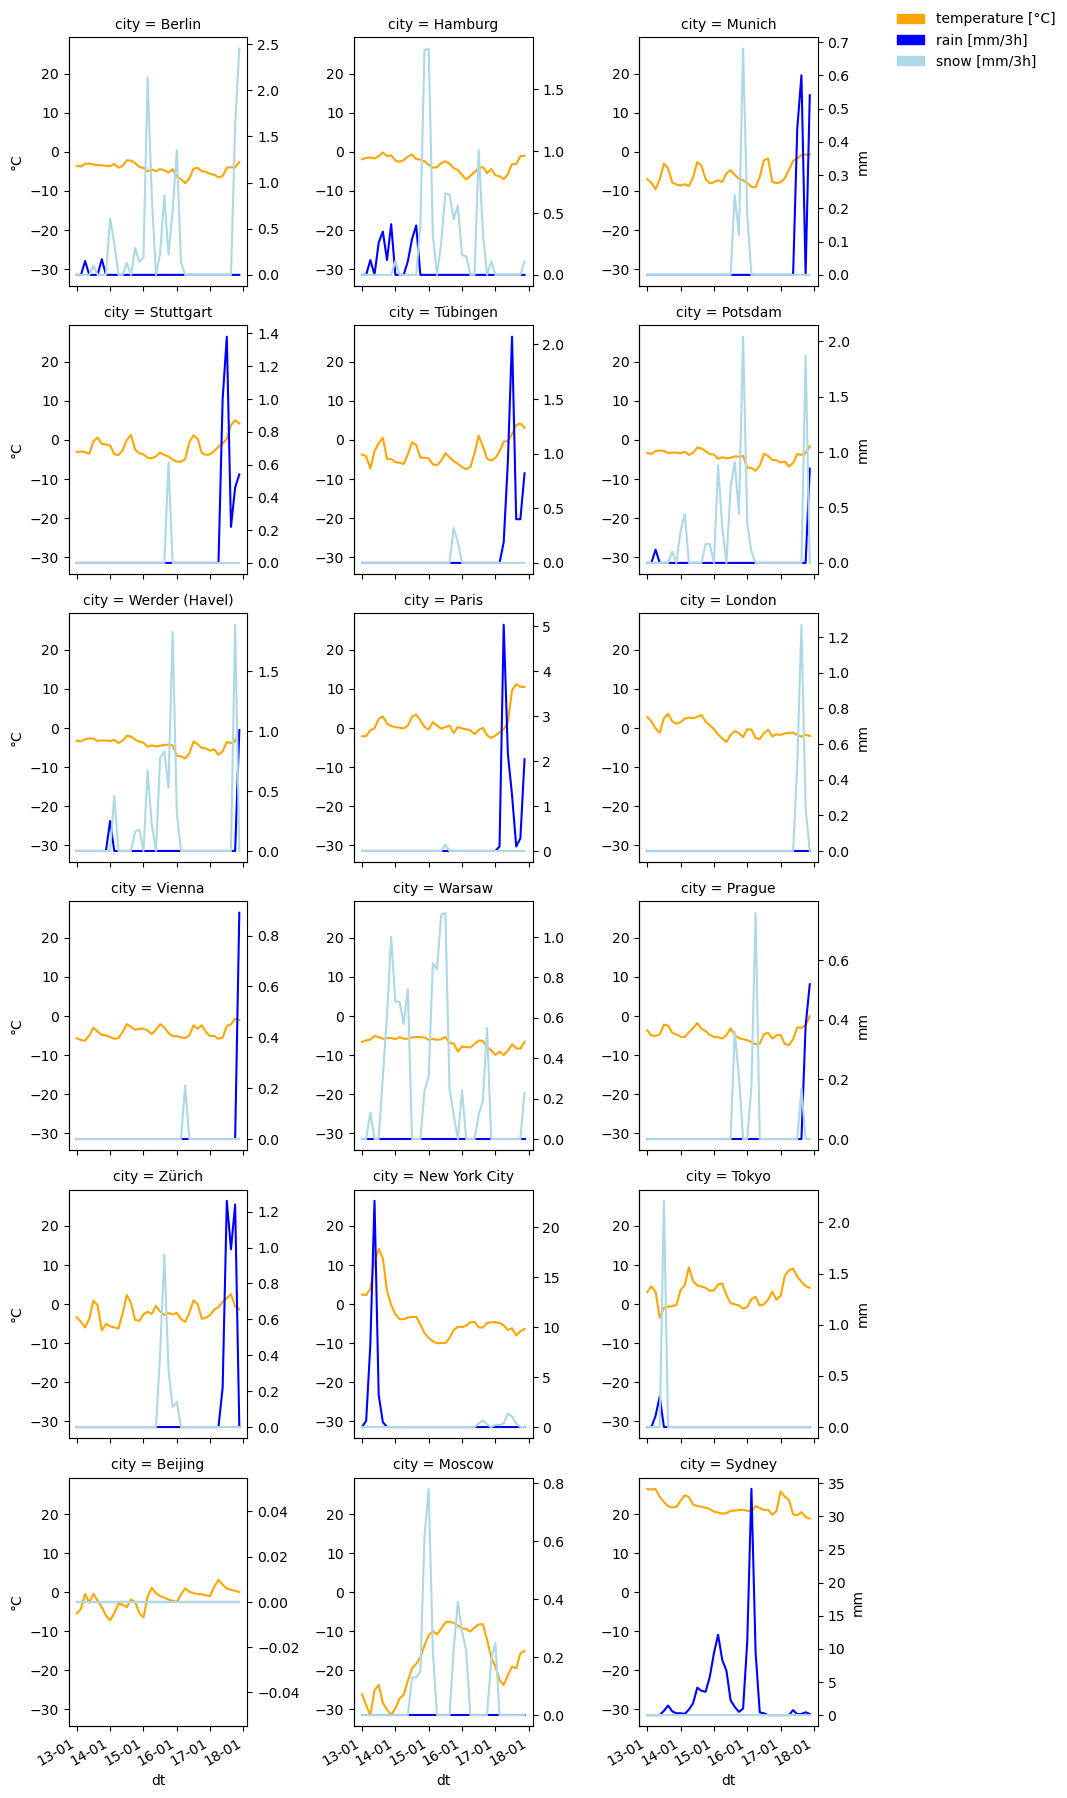

In [83]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

col_wrap = 3

g = sns.FacetGrid(
    data=joined_weather_df.drop(columns=["scrape_timestamp"]),
    col="city",
    col_wrap=col_wrap,
    sharex=True,
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
name_to_color = {
    "temperature [°C]": "orange",
    "rain [mm/3h]": "blue",
    "snow [mm/3h]": "lightblue",
}

patches = {k: mpatches.Patch(color=v) for k, v in name_to_color.items()}
g = g.map(plt.plot, "dt", "T_feelslike_celsius", color="orange").add_legend(patches)
g.set(ylabel="°C")
plt.gcf().autofmt_xdate()

for ax, ((i, j, k), subdata) in zip(g.axes, g.facet_data()):
    ax2 = ax.twinx()
    if j % col_wrap == col_wrap - 1:
        ax2.set(ylabel="mm")
    ax2.plot(subdata["dt"], subdata["rain_3h_mm"], color="blue")
    ax2.plot(subdata["dt"], subdata["snow_3h_mm"], color="lightblue")

g.tight_layout()
sns.move_legend(g, "upper right")